# Домашнее задание 2

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import optuna

import warnings
warnings.filterwarnings('ignore')

c:\python\python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Загрузка данных и генерация датасета

In [2]:
measurement_step = 100
series_len = 10
files = glob.glob('datasets/*.csv')


def get_dataset(measurement_step, series_len):
    files = glob.glob('dataset/*/*.csv')

    measurement_step = 10

    data = []
    for file in files:
        if(file != 'data_model.csv'):
            temp = pd.read_csv(file, usecols = ['u1', 'u2', 'y1', 'y2', 'y_nominal1', 'y_nominal2',
                                                'fault_u1', 'fault_u2', 'fault_y1', 'fault_y2', 'comp_fault'])
            indexes = range(0, temp.shape[0], measurement_step)
            temp = temp.iloc[indexes][:]
            #temp.reset_index(inplace=True)
            data.append(temp)      

    #Уберем строки, не относящиеся к отказу ИНС и заменим ненулевые значения отказов на 1.
    drop_cols = ['fault_u1', 'fault_u1', 'fault_u2', 'comp_fault']
    for experiment in data:
        experiment.drop(drop_cols, inplace=True, axis=1)
        experiment['fault_y1'].replace([1., 2., 3,], 1, inplace=True)
        experiment['fault_y2'].replace([1., 2., 3,], 1, inplace=True)
        
    #Заменим абсолютные значения выходов на отклонения
    for experiment in data:
        experiment['dev_y1'] = experiment['y_nominal1'] - experiment['y1']
        experiment['dev_y2'] = experiment['y_nominal2'] - experiment['y2']
        experiment.drop(['y1', 'y2', 'y_nominal1', 'y_nominal2'], inplace=True, axis=1)
        
    #Добавим первую и вторую производные
    for df1 in data:
        df1['V_dev_y1'] = df1['dev_y1'].shift(1) - df1['dev_y1']
        df1['V_dev_y2'] = df1['dev_y2'].shift(1) - df1['dev_y2']
        df1.dropna(axis=0, inplace=True)
        df1['A_dev_y1'] = df1['V_dev_y1'].shift(1) - df1['V_dev_y1']
        df1['A_dev_y2'] = df1['V_dev_y2'].shift(1) - df1['V_dev_y2']
        df1.dropna(axis=0, inplace=True)
        
    # Добавим скользящие средние на series_len и series_len/2
    cols = [col for col in data[0].columns if ('y1' in col or
                                        'y2' in col or
                                        'u1' in col) and 'fault' not in col]
    for df1 in data:
        for col in cols:
            df1['roll_5_' + col] = df1[col].rolling(series_len // 2).mean()
            df1['roll_10_' + col] = df1[col].rolling(series_len).mean()
        df1.dropna(axis=0, inplace=True)
        df1.reset_index(drop=True, inplace=True)
        
    #Сформируем датасет в виде временных последовательностей по series_len значений
    lag = series_len - 1
    new_cols = []
    for col in data[0].drop(['fault_y1', 'fault_y2'], axis=1).columns:
        new_cols += [col + '_' + str(i) for i in range(series_len)]
    new_cols += ['fault_y1', 'fault_y2']

    df = pd.DataFrame(data=None, columns=new_cols)
    cols = data[0].drop(['fault_y1', 'fault_y2'], axis=1).columns

    for k, experiment in enumerate(data):
        for i in range(lag, experiment.shape[0]):
            sample = []
            for col in cols:
                temp = list(experiment.loc[(i-lag):i][col])
                sample += temp
                
            sample_fault_y1 = list(experiment.loc[(i-lag):i]['fault_y1'])
            if sum(sample_fault_y1) == series_len:
                fault_y1_data = 1
            else:
                fault_y1_data = 0
                
            sample_fault_y2 = list(experiment.loc[(i-lag):i]['fault_y2'])
            if sum(sample_fault_y2) == series_len:
                fault_y2_data = 1
            else:
                fault_y2_data = 0
                
            sample += [fault_y1_data, fault_y2_data]
            df.loc[len(df)] = sample
            
    df['fault_LE'] = 0
    df['fault_LE'].loc[ (df['fault_y1'] == 0) & (df['fault_y1'] == 0)] = 0
    df['fault_LE'].loc[df['fault_y1'] == 1] = 1
    df['fault_LE'].loc[df['fault_y2'] == 1] = 2

    scaler = StandardScaler()
    X_array = scaler.fit_transform(df.drop(['fault_y1', 'fault_y2', 'fault_LE'], axis=1))
    y_le = np.array(df['fault_LE'])

    X_series = X_array.reshape((X_array.shape[0], series_len, int(X_array.shape[1] / series_len)))
    y_ohe = np.array(df[['fault_y1', 'fault_y2']])

    return df, X_array, y_le, X_series, y_ohe 

In [3]:
df, X_array, y_le, X_series, y_ohe = get_dataset(measurement_step, series_len)

X_array_train, X_array_test, y_le_train, y_le_test = train_test_split(X_array, y_le, stratify=y_le, test_size=0.25, random_state=0)

In [4]:
X_array_train.shape, y_le_train.shape

((25200, 220), (25200,))

In [5]:
col_names = df.drop(['fault_y1', 'fault_y2', 'fault_LE'], axis=1).columns

X_train, X_test = pd.DataFrame(X_array_train, columns=col_names), pd.DataFrame(X_array_test, columns=col_names)
y_train, y_test = pd.DataFrame(y_le_train, columns=['fault']), pd.DataFrame(y_le_test, columns=['fault'])
X_train.shape, y_train.shape

((25200, 220), (25200, 1))

## Построение модели
В ходе выоплнения первого задания достаточно высокую точность показал случайный лес при низких вычислительных затратах в сравнении с аналогами по выбранной метрике. Проведем подбор его гиперпараметров с применением optuna

In [6]:
def objective(trial, X, y, cv):

  params = params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
        }
  rf_clf = RandomForestClassifier(**params, random_state=0)
  cv_result = cross_validate(rf_clf, X, y, cv = cv, scoring=['precision_macro', 'recall_macro'], n_jobs = -1)
  precision = cv_result ["test_precision_macro"].mean()
  recall = cv_result ["test_recall_macro"].mean()
  f1 = 2* precision * recall / (precision + recall)
  return f1

In [7]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
func = lambda trial: objective(trial, X_train, y_train, cv=kf)

study = optuna.create_study(direction="maximize")
study.optimize(func, n_trials=30)

[I 2024-02-17 12:59:15,317] A new study created in memory with name: no-name-e9fcb193-a699-49db-8c68-e80388b03555
[I 2024-02-17 13:10:12,458] Trial 0 finished with value: 0.8235047743254286 and parameters: {'n_estimators': 654, 'max_depth': 36, 'min_samples_split': 135, 'min_samples_leaf': 44}. Best is trial 0 with value: 0.8235047743254286.
[I 2024-02-17 13:22:41,705] Trial 1 finished with value: 0.8382792938955631 and parameters: {'n_estimators': 661, 'max_depth': 35, 'min_samples_split': 75, 'min_samples_leaf': 17}. Best is trial 1 with value: 0.8382792938955631.
[I 2024-02-17 16:04:21,633] Trial 2 finished with value: 0.8335841793758818 and parameters: {'n_estimators': 882, 'max_depth': 32, 'min_samples_split': 14, 'min_samples_leaf': 26}. Best is trial 1 with value: 0.8382792938955631.
[I 2024-02-17 16:20:28,807] Trial 3 finished with value: 0.8344644223823995 and parameters: {'n_estimators': 803, 'max_depth': 34, 'min_samples_split': 114, 'min_samples_leaf': 19}. Best is trial 1 

Проведем обучение модели с оптимизированными гиперпараметрами

In [8]:
best_params = study.best_params
best_params

{'n_estimators': 446,
 'max_depth': 48,
 'min_samples_split': 47,
 'min_samples_leaf': 1}

In [9]:
rf_clf = RandomForestClassifier(**best_params)

In [10]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=48, min_samples_split=47, n_estimators=446)

In [11]:
X_array_train.shape

(25200, 220)

Оценим качество на отложенной выборке

In [12]:
predictions = rf_clf.predict(X_array_test)

In [13]:
f1 = f1_score(y_le_test, predictions, average='macro')
print(f'f1-score: {f1}')
print(classification_report(y_le_test, predictions))

f1-score: 0.8654091173392043
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      6136
           1       0.99      0.75      0.85      1104
           2       0.95      0.69      0.80      1160

    accuracy                           0.92      8400
   macro avg       0.95      0.81      0.87      8400
weighted avg       0.92      0.92      0.91      8400



In [14]:
print(confusion_matrix(y_le_test, predictions))

[[6081   12   43]
 [ 277  827    0]
 [ 360    0  800]]


## Интерпретация модели
Датасет имеет большое количество признаков. поэтому сперва определим только наиболее значимую часть

In [31]:
features = {}
for i in range(len(X_test.columns)):
    features[rf_clf.feature_names_in_[i]] = rf_clf.feature_importances_[i]

In [32]:
features = sorted( features.items(), key=lambda pair: pair[1], reverse=True )[:20]
features

[('dev_y1_9', 0.03697317949081328),
 ('dev_y2_9', 0.03369950787514707),
 ('roll_5_dev_y2_9', 0.02516596607751467),
 ('dev_y2_7', 0.022326804170204814),
 ('dev_y1_8', 0.02194700488596019),
 ('dev_y2_8', 0.02102348579230677),
 ('roll_10_V_dev_y1_9', 0.01901107815892614),
 ('roll_5_dev_y1_9', 0.0178169335891656),
 ('dev_y1_7', 0.01618648689624056),
 ('roll_5_dev_y2_8', 0.015959012751671012),
 ('roll_5_V_dev_y1_9', 0.015517344937291042),
 ('roll_5_dev_y2_7', 0.014738020646267473),
 ('roll_10_V_dev_y2_9', 0.013979163962798975),
 ('V_dev_y1_9', 0.013906156377516639),
 ('dev_y2_6', 0.01389051844771998),
 ('roll_10_dev_y1_9', 0.013628050131712444),
 ('A_dev_y1_9', 0.0134236367632522),
 ('roll_10_dev_y2_9', 0.013173435723498994),
 ('roll_5_dev_y1_8', 0.012371850958306962),
 ('roll_10_V_dev_y1_8', 0.011555934069524322)]

#### Mean Decrease Impurity

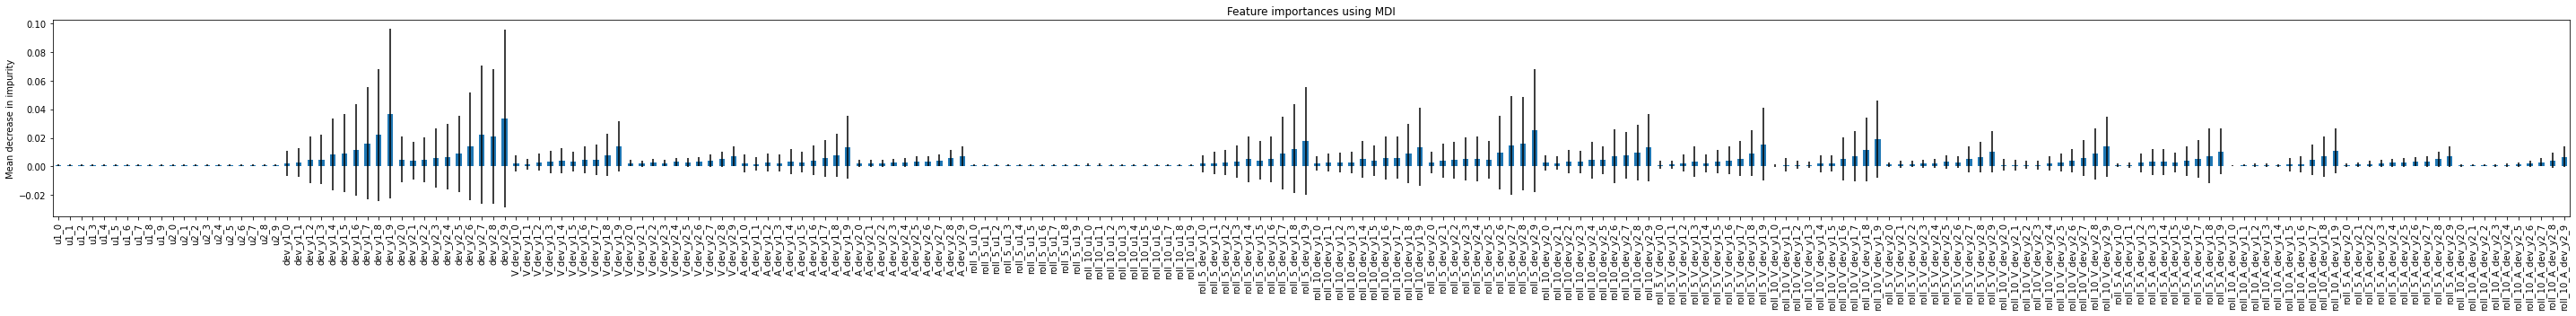

In [33]:

forest_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns)

fig, ax = plt.subplots(figsize=(40, 5))
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity", )
fig.tight_layout()